In [23]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [1]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)
  data_path = 'gdrive/MyDrive/cds-project/data/emotions-nlp/' # Replace with path to datasets in your g drive
  glove_path = 'gdrive/MyDrive/cds-project/glove.6B.100d.txt'
else:
  data_path = '../data/emotions-nlp/' # Replace with path to datasets on local machine
  glove_path = '../glove_model/glove.6B.100d.txt'
print("Reading dataset from path " + data_path)

Mounted at /content/gdrive
Reading dataset from path gdrive/MyDrive/cds-project/data/emotions-nlp/


In [2]:
# Import dataset
import pandas as pd

df_train = pd.read_csv(data_path + 'processed_train.csv')
df_test = pd.read_csv(data_path + 'processed_test.csv')
df_val = pd.read_csv(data_path + 'processed_val.csv')

df_train.head(10)

,text,emotion
0,didnt feel humiliated,sadness
1,go feeling hopeless damned hopeful around some...,sadness
2,im grabbing minute post feel greedy wrong,anger
3,ever feeling nostalgic fireplace know still pr...,love
4,feeling grouchy,anger
5,ive feeling little burdened lately wasnt sure,sadness
6,ive taking milligrams times recommended amount...,surprise
7,feel confused life teenager jaded year old man,fear
8,petronas years feel petronas performed well ma...,joy
9,feel romantic,love


# Encoding text and emotions

In [6]:
# Calculate text lengths
df_train['text_length'] = df_train['text'].apply(lambda txt: len(txt.split()))
df_test['text_length'] = df_test['text'].apply(lambda txt: len(txt.split()))
df_val['text_length'] = df_val['text'].apply(lambda txt: len(txt.split()))
df_train.head()

,text,emotion,text_length
0,didnt feel humiliated,sadness,3
1,go feeling hopeless damned hopeful around some...,sadness,9
2,im grabbing minute post feel greedy wrong,anger,7
3,ever feeling nostalgic fireplace know still pr...,love,7
4,feeling grouchy,anger,2


In [7]:
# Convert emotion to integer
emotions = df_train['emotion'].unique()
emotion_to_id = {}
for id in range(len(emotions)):
  e = emotions[id]
  emotion_to_id[e] = id
output_size = len(emotion_to_id)

In [8]:
df_train['emotion_id'] = df_train['emotion'].apply(lambda e: emotion_to_id[e])
df_test['emotion_id'] = df_test['emotion'].apply(lambda e: emotion_to_id[e])
df_val['emotion_id'] = df_val['emotion'].apply(lambda e: emotion_to_id[e])
df_train.head()

,text,emotion,text_length,emotion_id
0,didnt feel humiliated,sadness,3,0
1,go feeling hopeless damned hopeful around some...,sadness,9,0
2,im grabbing minute post feel greedy wrong,anger,7,1
3,ever feeling nostalgic fireplace know still pr...,love,7,2
4,feeling grouchy,anger,2,1


# Create vocabulary

In [9]:
# Tokenize the text

def tokenize(text):
  return [word for word in text.split()]

In [10]:
# Build vocabulary
from collections import Counter, OrderedDict

all_text = pd.concat([df_train['text'], df_test['text'], df_val['text']])

counts = Counter()
for text in all_text:
  counts.update(tokenize(text))

In [11]:
# Delete infrequently occuring words
print("Number of words before cleaning vocabulary: ", len(counts.keys()))
print("Cleaning vocabulary...")
for word in list(counts):
  if counts[word] < 2:
    del counts[word]
print("Number of words after cleaning vocabulary: ", len(counts.keys()))

Number of words before cleaning vocabulary:  16947
Cleaning vocabulary...
Number of words after cleaning vocabulary:  8279


In [12]:
# Create vocabulary

vocab2index = {"": 0, "UNK":1}
words = list(vocab2index.keys())
for word in counts:
  vocab2index[word] = len(words)
  words.append(word)

In [13]:
# Create Vocab object
from torchtext.vocab import vocab
ordered_dict = OrderedDict(counts.most_common())
vocab = vocab(ordered_dict)

# insert special tokens and set default index to 'unknown'
vocab.insert_token('<PAD>', 0)
vocab.insert_token('<UNK>', 1)
vocab.set_default_index(1)

In [14]:
import numpy as np

def encode_sentence(text, vocab2index, N=70):
  tokenized = tokenize(text)
  encoded = np.zeros(N, dtype=int)
  enc = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
  length = min(N, len(enc))
  encoded[:length] = enc[:length]
  return encoded, length

In [15]:
df_train['encoded'] = df_train['text'].apply(lambda txt: np.array(encode_sentence(txt, vocab2index), dtype=object))
df_test['encoded'] = df_test['text'].apply(lambda txt: np.array(encode_sentence(txt, vocab2index), dtype=object))
df_val['encoded'] = df_val['text'].apply(lambda txt: np.array(encode_sentence(txt, vocab2index), dtype=object))
df_train.head()

,text,emotion,text_length,emotion_id,encoded
0,didnt feel humiliated,sadness,3,0,"[[2, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,go feeling hopeless damned hopeful around some...,sadness,9,0,"[[5, 6, 7, 8, 9, 10, 11, 12, 13, 0, 0, 0, 0, 0..."
2,im grabbing minute post feel greedy wrong,anger,7,1,"[[14, 15, 16, 17, 3, 18, 19, 0, 0, 0, 0, 0, 0,..."
3,ever feeling nostalgic fireplace know still pr...,love,7,2,"[[20, 6, 21, 22, 23, 24, 25, 0, 0, 0, 0, 0, 0,..."
4,feeling grouchy,anger,2,1,"[[6, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


# Create GloVe embedding matrix

In [16]:
import torchtext as text

embedding_dim = 100

try:
  vec = text.vocab.GloVe(name='6B', dim=embedding_dim)
  word_emb = vec.get_vecs_by_tokens(vocab.get_itos())
except:
  # Load embedding directly from text file
  print("\nLoading GloVe model from " + glove_path + "...")
  glove_model = {}
  with open(glove_path, 'r') as f:
    for line in f:
      split_line = line.split()
      word = split_line[0]
      embedding = np.array(split_line[1:], dtype=np.float64)
      glove_model[word] = embedding
  print(f"{len(glove_model)} words loaded")

  # Build embedding matrix
  vocab_size = len(vocab.get_itos())
  word_emb = np.zeros((vocab_size, embedding_dim))

  for i, w in enumerate(vocab.get_itos()):
    if i < vocab_size:
      embedding_vector = glove_model.get(w, None)
      if embedding_vector is not None:
        word_emb[i] = embedding_vector

  # Convert to tensor
  word_emb = torch.Tensor(word_emb)

.vector_cache/glove.6B.zip: 862MB [02:40, 5.36MB/s]                           
100%|█████████▉| 399999/400000 [00:22<00:00, 17520.49it/s]


# LSTM with Pretrained GloVe word embeddings

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self, word_vec, embed_dim, output_size, hidden_dim = 100, num_layers=2, dropout=0.2):
    super().__init__()
    self.embedding = nn.Embedding(*(word_vec.size())).from_pretrained(word_vec, freeze=False)
    self.embedding.weight.requires_grad = False # Freeze embeddings
    self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, num_layers=num_layers, batch_first=True)
    self.linear = nn.Linear(4 * hidden_dim, 64)
    self.dropout = nn.Dropout(dropout)
    self.relu = nn.ReLU()
    self.out = nn.Linear(64, output_size)

  def forward(self, text):
    embedded = self.embedding(text)
    embedded = torch.squeeze(torch.unsqueeze(embedded, 0))

    h_lstm, _ = self.lstm(embedded)
    avg_pool = torch.mean(h_lstm, 1)
    max_pool, _ = torch.max(h_lstm, 1)
    conc = torch.cat((avg_pool, max_pool), 1)
    conc = self.relu(self.linear(conc))
    conc = self.dropout(conc)
    out = self.out(conc)
    return out

# Create Dataset and DataLoaders

In [18]:
from torch.utils.data import Dataset, DataLoader

class EmotionDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [19]:
train_dataset = EmotionDataset(df_train['encoded'], df_train['emotion_id'])
test_dataset = EmotionDataset(df_test['encoded'], df_test['emotion_id'])
val_dataset = EmotionDataset(df_val['encoded'], df_val['emotion_id'])

In [20]:
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Train and evaluate model

In [25]:
from sklearn.metrics import mean_squared_error

def train_model(model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    train_losses, val_losses, accuracies = [], [], []
    epochs_run = 0
    N = 10
    running_val_loss = 0
    epoch_counter = 0

    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dataloader:
            x = x.long().to(device)
            y = y.long().to(device)
            y_pred = model(x)
            optimizer.zero_grad()
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        epochs_run += 1
        val_loss, val_acc = validation_metrics(model, val_dataloader)
        train_loss = sum_loss/total
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        accuracies.append(val_acc)

        print("epoch {0} | train loss {1:.3f}, val loss {2:.3f}, val accuracy {3:.3f}".format(i, train_loss, val_loss, val_acc))

        # Early stopping to minimise loss
        if (running_val_loss <= val_loss):
          epoch_counter += 1
          if (epoch_counter == N):
            print(f"Early stopped after {i + 1} epochs")
            break
        else:
          running_val_loss = val_loss
          epoch_counter = 0

    return train_losses, val_losses, accuracies, epochs_run

def validation_metrics(model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0

    for x, y, l in valid_dl:
        x = x.long().to(device)
        y = y.long().to(device)
        y_hat = model(x)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        
    return sum_loss/total, correct/total

In [26]:
model = Net(word_vec=word_emb, embed_dim=embedding_dim, output_size=output_size).to(device)

train_losses, val_losses, accuracies, epochs_run = train_model(model, epochs=30)

epoch 0 | train loss 1.597, val loss 1.577, val accuracy 0.383
epoch 1 | train loss 1.530, val loss 1.465, val accuracy 0.430
epoch 2 | train loss 1.323, val loss 1.137, val accuracy 0.588
epoch 3 | train loss 0.924, val loss 0.775, val accuracy 0.732
epoch 4 | train loss 0.601, val loss 0.596, val accuracy 0.796
epoch 5 | train loss 0.402, val loss 0.504, val accuracy 0.821
epoch 6 | train loss 0.290, val loss 0.456, val accuracy 0.845
epoch 7 | train loss 0.210, val loss 0.415, val accuracy 0.858
epoch 8 | train loss 0.170, val loss 0.383, val accuracy 0.868
epoch 9 | train loss 0.131, val loss 0.426, val accuracy 0.866
Early stopped after 10 epochs


In [29]:
# Show training results
import matplotlib.pyplot as plt

def show_results(train_losses, val_losses, accuracies, epochs):
  x = [e for e in range(1, epochs + 1)]

  # show loss results
  plt.plot(x, train_losses, color='b', label='Training loss')
  plt.plot(x, val_losses, color='r', label='Validation loss')
  plt.legend()
  plt.xlabel('epochs')
  plt.title('Loss')
  plt.show()

  # show accuracy results
  plt.plot(x, accuracies)
  plt.xlabel('epochs')
  plt.title('Training accuracy using validation set')
  plt.show()

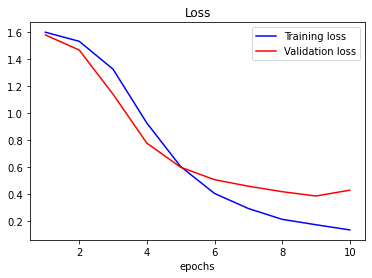

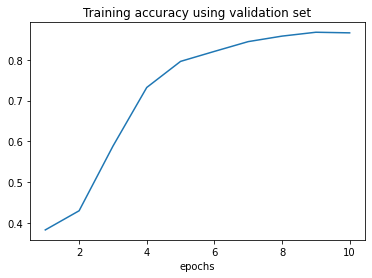

In [30]:
show_results(train_losses, val_losses, accuracies, epochs_run)

In [63]:
# Evaluate model with test set
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

def evaluate_model(model, test_dl, classes):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    y_test, y_pred = [], []

    with torch.no_grad():
      for x, y, l in test_dl:
        x = x.long().to(device)
        y = y.long().to(device)
        y_hat = model(x)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        y_test += y.tolist()
        y_pred += pred.tolist()

    conf = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(conf)

    print('\nAccuracy: {0:.3f}, cross entropy loss: {1:.3f}'.format(accuracy_score(y_test, y_pred), sum_loss/total))

    print('\nClassification Report\n')
    print(classification_report(y_test, y_pred, target_names=classes))

labels = list(emotion_to_id.keys())
evaluate_model(model, test_dataloader, labels)

Confusion Matrix:
[[531  12   1   1  17  19]
 [ 17 230   0   0  18  10]
 [  4   5 107   3   0  40]
 [  1   0   0  46  13   6]
 [  8   4   0  19 190   3]
 [ 17  15  30   3   9 621]]

Accuracy: 0.863, cross entropy loss: 0.398

Classification Report

              precision    recall  f1-score   support

     sadness       0.92      0.91      0.92       581
       anger       0.86      0.84      0.85       275
        love       0.78      0.67      0.72       159
    surprise       0.64      0.70      0.67        66
        fear       0.77      0.85      0.81       224
         joy       0.89      0.89      0.89       695

    accuracy                           0.86      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.86      0.86      0.86      2000

